# Specific game attributes for Feb 25 pilot

In [57]:
%pylab inline
import scipy.stats as stats
import itertools
import pandas as pd
import networkx as nx
from lifelines import CoxTimeVaryingFitter
import json
from collections import Counter
from measure_experiment import *

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'f', 'select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [67]:
export_dir = "../../results-sensitive/pilot/20200225/json/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.json', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2019-11-27T18:20:38.972Z panel_0_matched_pair_exp_design5_matched_20191125_173028
1 2019-12-11T17:08:10.631Z panel_0_matched_pair_exp_design5_matched_20191211_112322
2 2019-12-11T18:21:08.701Z panel_0_matched_pair_exp_design5_matched_20191211_112322
3 2019-12-18T15:21:44.815Z test
4 2019-12-18T15:58:20.952Z small
5 2020-01-16T17:36:13.359Z panel_1_matched_pair_exp_design5_matched_20191211_112322
6 2020-02-24T18:08:42.538Z solotest
7 2020-02-24T18:20:09.033Z solotest
8 2020-02-24T18:56:53.687Z 1player_39bots
9 2020-02-25T18:59:30.743Z testsolo6
10 2020-02-25T18:59:52.865Z testsolo6
11 2020-02-25T20:36:00.288Z panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320
12 2020-02-25T20:36:39.337Z panel_0_matched_pair_exp_design6_matched_20200224_122320


In [133]:
# select which games to process
# Game 1 was a test game, for practice

select = [12]
process_games = [loaded_games[i] for i in select]
for game in process_games:
    print(i, game['createdAt'], game['gameSetupId'])

12 2020-02-25T20:36:39.337Z panel_0_matched_pair_exp_design6_matched_20200224_122320


In [134]:
for player_id, player in game['players'].items():
    if 'workerId' in player['urlParams'].keys():
        player['name'] = player['urlParams']['workerId']
    else:
        player['name'] = player['id']

In [135]:
t_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='t']
c_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='c']

In [136]:
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

game_log = pd.DataFrame(game['log'])
game_log['logTime'] = game_log['createdAt'].apply(lambda s: datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ'))
game_log['t'] = game_log['logTime'] - t_start
game_log

,_id,playerId,gameId,roundId,stageId,name,jsonData,createdAt,data,logTime,t
0,HEH78m5qiXCETbcAe,uKf2C8XwnvSLEXbL4,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,navigation,"""Pageload""",2020-02-25T20:36:43.321Z,Pageload,2020-02-25 20:36:43.321,00:00:03.984000
1,ESpDEdr3zbhAh8296,NQapWrnKNTMmX6dbL,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,navigation,"""Pageload""",2020-02-25T20:36:43.423Z,Pageload,2020-02-25 20:36:43.423,00:00:04.086000
2,zcCPNg9sgTCSPnFyi,3BgWNtKCh8uB4NuAP,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,navigation,"""Pageload""",2020-02-25T20:36:43.427Z,Pageload,2020-02-25 20:36:43.427,00:00:04.090000
3,FbXivzjJRqa3RtSpW,ghLWq5ffrcXuW9Mh7,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,navigation,"""Pageload""",2020-02-25T20:36:43.433Z,Pageload,2020-02-25 20:36:43.433,00:00:04.096000
4,rLeFQXE2bnRhYBoBK,tMRkpHPYvRPx4mqA7,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,navigation,"""Pageload""",2020-02-25T20:36:43.437Z,Pageload,2020-02-25 20:36:43.437,00:00:04.100000
...,...,...,...,...,...,...,...,...,...,...,...
2625,ZLME2dhsRtdF8KA9q,3BgWNtKCh8uB4NuAP,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,pickup,"{""clue"":""tclue_2_7"",""source"":""promising_leads""}",2020-02-25T20:44:42.317Z,"{'clue': 'tclue_2_7', 'source': 'promising_lea...",2020-02-25 20:44:42.317,00:08:02.980000
2626,T6TtFnkor42Wn3bWL,TvZGN4t9w9E4zayrL,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,drop,"{""clue"":""tclue_1_9"",""source"":""dead_ends"",""dest...",2020-02-25T20:44:42.384Z,"{'clue': 'tclue_1_9', 'source': 'dead_ends', '...",2020-02-25 20:44:42.384,00:08:03.047000
2627,ycAZZWgnZ3HRuFvpj,8YuFCLWx99ppEojkh,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,pickup,"{""clue"":""tclue_1_5"",""source"":""sxYt7qiNYJLoxmZMW""}",2020-02-25T20:44:42.399Z,"{'clue': 'tclue_1_5', 'source': 'sxYt7qiNYJLox...",2020-02-25 20:44:42.399,00:08:03.062000
2628,6J2nQc7apq2bqbqvc,TvZGN4t9w9E4zayrL,myD6h4igY5pDRAeuG,bjvdo9nMh8kAbfWk6,aGbCN88i9SvrgvK7c,pickup,"{""clue"":""tclue_2_9"",""source"":""dead_ends""}",2020-02-25T20:44:42.892Z,"{'clue': 'tclue_2_9', 'source': 'dead_ends'}",2020-02-25 20:44:42.892,00:08:03.555000


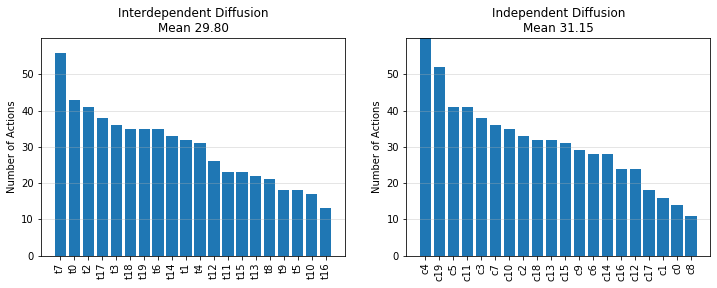

In [137]:
plt.figure(figsize=(12,4))

counts = game_log[game_log['name'] == 'drop'][['playerId', '_id']].groupby('playerId').count()

log_length = {}
for pid in t_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,1)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Interdependent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

log_length = {}
for pid in c_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,2)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Independent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

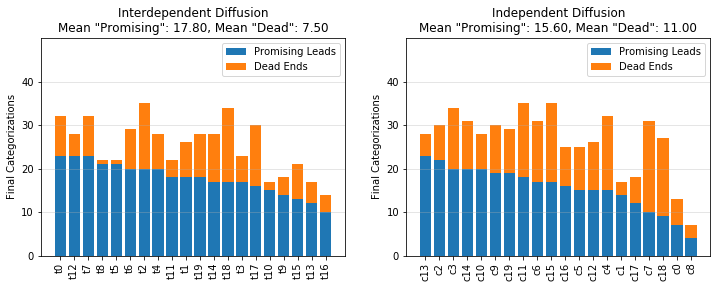

In [138]:
plt.figure(figsize=(12,4))

promising = {}
dead = {}
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,1)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Interdependent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));


promising = {}
dead = {}
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,2)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Independent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));

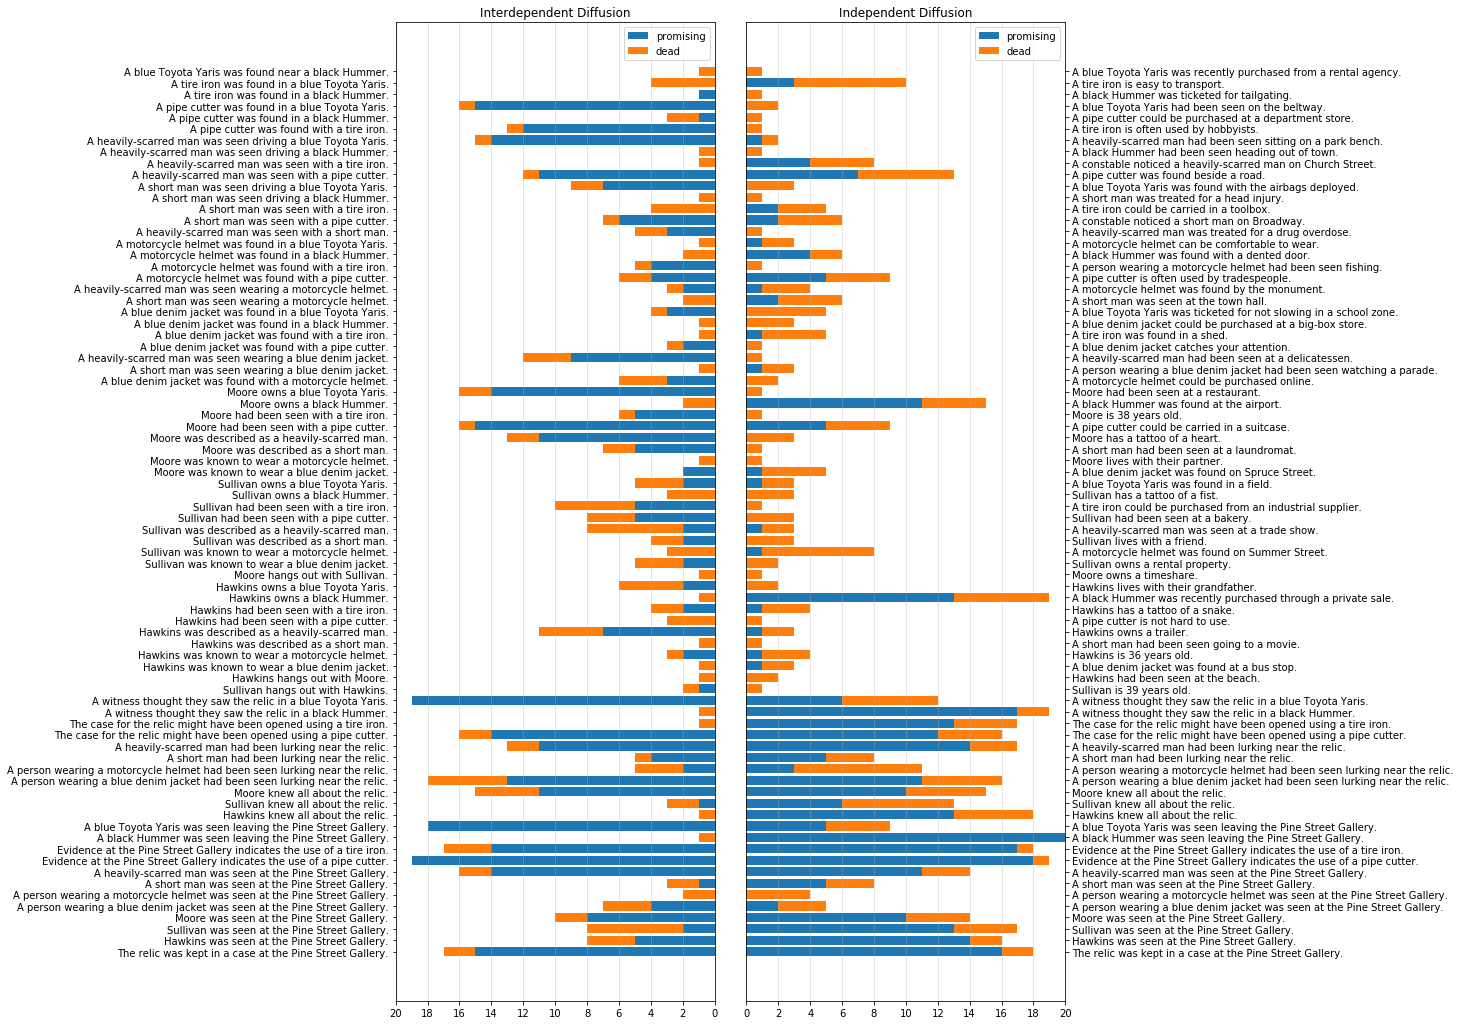

In [139]:

plt.figure(figsize=(12,18))

promising = Counter()
dead = Counter()
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1
            
axl = plt.subplot(1,2,1)       
#order = list(set(promising.keys()).union(set(dead.keys())))
order = [k for k in game['data.clues'].keys() if k[0]=='t']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.box('off')
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.grid('on', axis='x', alpha=.4)
plt.title('Interdependent Diffusion');
axl.invert_xaxis()
inter_promising = promising
inter_order = order

promising = Counter()
dead = Counter()
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1

axr = plt.subplot(1,2,2)       
order = [k for k in game['data.clues'].keys() if k[0]=='c']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.box('off')
plt.grid('on', axis='x', alpha=.4)
plt.title('Independent Diffusion');
axr.yaxis.tick_right()
plt.subplots_adjust(wspace=.1)

indep_promising = promising
indep_order = order


In [125]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in inter_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Treatment: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([inter_promising[cl] for cl in spoke])/23, np.sum([inter_promising[cl] for cl in nonspoke])/55))

spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in indep_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Control: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([indep_promising[cl] for cl in spoke])/23, np.sum([indep_promising[cl] for cl in nonspoke])/55))

Treatment: 7.61 adoptions per spoke, 3.29 adoptions per nonspoke
Control: 10.48 adoptions per spoke, 1.29 adoptions per nonspoke


3.117532399905863

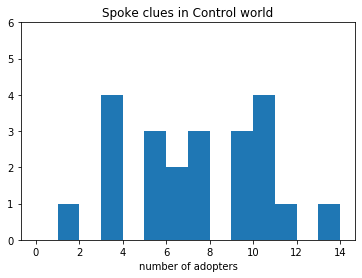

In [115]:
spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([indep_promising[cl] for cl in spoke], bins=range(15))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Control world')
#len(spoke)
#sum([indep_promising[cl] for cl in spoke])
np.std([indep_promising[cl] for cl in spoke])

3.445066142416366

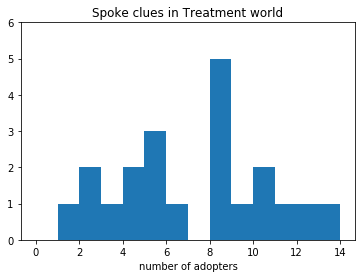

In [117]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([inter_promising[cl] for cl in spoke], bins=range(15))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Treatment world')
#len(spoke)
#sum([inter_promising[cl] for cl in spoke])
np.std([inter_promising[cl] for cl in spoke])

# idle check

In [13]:
activity = {}
for player_id, player in game['players'].items():
    if 'data.active' in player.keys():
        activity[player['data.position']] = player['data.active']

activity


{'c13': 'idle once',
 't2': 'idle once',
 'c15': 'idle once',
 'c7': 'idle once',
 't18': 'idle once',
 't17': 'idle once',
 'c18': 'idle once',
 't9': 'idle once'}

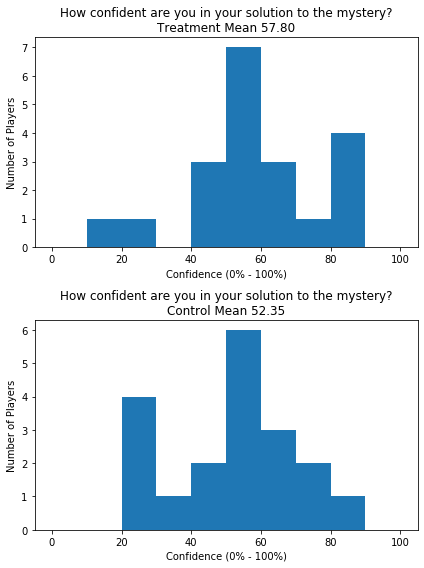

In [14]:
plt.figure(figsize=(6,8))

confidences = []
consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,1)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nTreatment Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)

confidences = []
consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,2)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nControl Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('confidence.png', transparent=True, dpi=500, bbox_inches='tight')



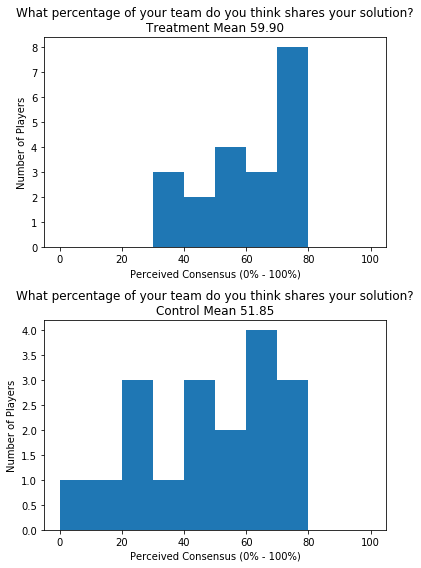

In [15]:
plt.figure(figsize=(6,8))


consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,1)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nTreatment Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)


consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,2)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nControl Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('consensus.png', transparent=True, dpi=500, bbox_inches='tight')


In [103]:
import string
fair = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'fair' in player['data.survey'].keys():
            s = player['data.survey']['fair']
            fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(fair).value_counts()
pd.DataFrame(counts)


,0
yes,24
yes although the organization of getting people to sign in at 230 or 330 was haphazard,1
yes very fair,1
seems about right thanks,1
yes thank you,1
more than fair,1
as long as you pay the bonus yes,1
yes it was great,1
not sure,1
mostly perhaps a bit underpaid,1


In [104]:
length = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'time' in player['data.survey'].keys():
            s = player['data.survey']['time']
            length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(length).value_counts()
pd.DataFrame(counts)

,0
yes,32
yes i think i had plenty,1
yes it took a little time to read all the clues,1
new clues came up not sure where they came from some right before the time ran out there were very few mentions of names i started to wonder if i was seeing all of the information,1
i already made my mind around the 3m mark,1
yup,1
plenty,1
yes it was more than enough time,1
i think so,1


In [105]:
feedback = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'feedback' in player['data.survey'].keys():
            s = player['data.survey']['feedback']
            feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(feedback).value_counts()
pd.DataFrame(counts)

,0
,11
none,7
na,2
none thanks,1
super fun hit wish all mturk experiments were like this,1
slightly difficult to move clues,1
no issues i mainly just which the notepad we put clues on was a bit more horizontal and let at least two leads or dead ends be next to each other just slightly ui changes to make things easier,1
no problems encountered,1
good hit no problems,1
it was fun lets do this again,1


In [107]:
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'strategy' in player['data.survey'].keys():
            print('\n', player['data.survey']['strategy'])
            
        


 I tried to use the clues that I saw across multiple collaborators that seemed to strongly fit with one another to create my list of leads.

 to pick things that seem to help solve the case and were important 

 I looked into what seemed the most likely and which clues matched each other.

 Just trying to take it all in and stay consistent for better or worse

 Just tried to pick what made sense

 just look over everything

 I tried to see which leads connected together and would explain things best.

 looking at all the clues and organizing everything sounded pretty legit

 I just tried to find several items that corrobated each other and avoided using anything I was unsure of

 I just tried to go with my gut feeling about the likely scenarios and clues that mattered.

 kind of guessed

 I tried to find clues that were common to all the detectives

 I tried to piece together a story chronologically that made sense.

 I just did my best to look at all the clues, and then I tried to fo

# Retrace logs

['Moore', 'a motorcycle helmet'] no longer in source gpZspo4BMkvAseucJ
['Moore', '38'] no longer in source W62nrytMGhSPABEze


(0, 1.6012499999999998)

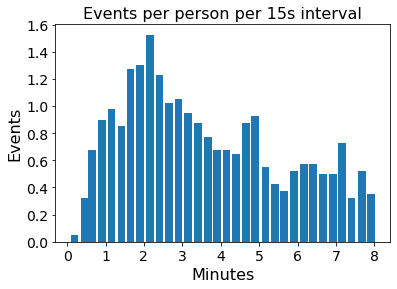

In [108]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
            assert source in game['playerIds']  # check that source is another player
            if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
                # this can fail if the exposer removes the clue while the exposed is dragging it.
                # turns out not to be a big deal
                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       



ts = list(range(0,9*60,15))
events = 0
xs = []
events_list = []

for (player_id, g, t) in retrace(game):
    if t >= ts[0]:
        events_list.append(events)
        xs.append(t)
        ts.pop(0)
    events+=1


plt.bar(xs[1:], np.diff(events_list)/40, width=-12, align='edge')
plt.title("Events per person per 15s interval", fontsize=16)
plt.xlabel("Minutes", fontsize=16)
plt.ylabel("Events", fontsize=16)
plt.xticks(range(0, 481, 60), range(0,9), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0)